# EA1:

*By Daniel Deutsch and José Lucas Barretto*

In [89]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.tsa.stattools as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA as arima

In [19]:
# Matplotlib styles
plt.style.use('ggplot')
plt.rcParams.update({
    'figure.figsize': (15, 4),
    'axes.prop_cycle': plt.cycler(color=["#4C72B0", "#C44E52", "#55A868", "#8172B2", "#CCB974", "#64B5CD"]),
    'axes.facecolor': "#EAEAF2"
})

## Moody's AAA Corporate Bond Yields

### Load the Data

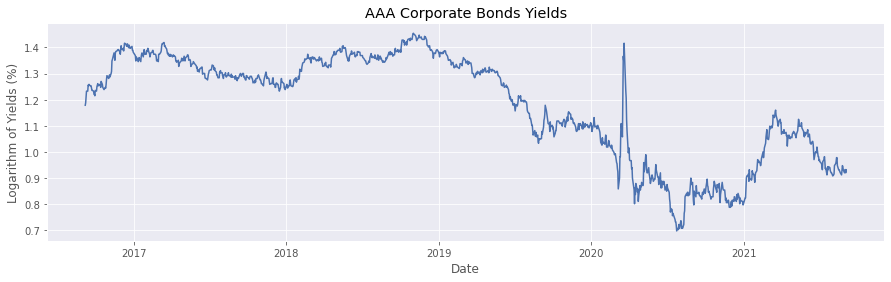

In [20]:
# Loads data and makes small modifications on the df
df_aaa = pd.read_csv("datasets/AAA_corpbonds_yields.csv", na_values='.')
df_aaa['DATE'] = pd.to_datetime(df_aaa['DATE'], format='%Y-%m-%d')
df_aaa.rename(columns={'DATE': 'date', 'DAAA': 'value'}, inplace=True)
df_aaa.dropna(inplace=True)

# Applies log-transform
df_aaa['value'] = np.log(df_aaa['value'])

# Plots the time series
plt.plot(df_aaa['date'], df_aaa['value'])
plt.title("AAA Corporate Bonds Yields")
plt.xlabel("Date")
plt.ylabel("Logarithm of Yields (%)")
plt.show()

### Augmented Dickey-Fuller Test

First, we shall perform the Augmented Dickey-Fuller test to verify if the series has a drift/deterministic trend, and if it has a unit root. The test has the following as hypotesis:

<br>

$$
    H_0: \text{there is a unit root.} \\
    H_1: \text{there is no unit root (the time series is stationary).}
$$

<br>

If the pvalue is above a critical size, then we cannot reject that there is a unit root. We start by running a general regression (includes constant and trend).

In [23]:
adf_res = sm.adfuller(df_aaa['value'], regression='ct', maxlag=12, autolag='AIC', regresults=True)
print('ADF Results (Constant + Trend):')
print('t-value:', adf_res[0])
print('p-value:', adf_res[1])
print('used lags:', adf_res[3].usedlag)
print(adf_res[3].resols.summary())

ADF Results (Constant + Trend):
t-value: -2.6364122978936644
p-value: 0.263419911735774
used lags: 9
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     4.897
Date:                Sun, 12 Sep 2021   Prob (F-statistic):           1.86e-07
Time:                        17:35:03   Log-Likelihood:                 3346.4
No. Observations:                1241   AIC:                            -6669.
Df Residuals:                    1229   BIC:                            -6607.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

1. We verify that p-value for the ADF is not low enough, which means that we do not reject $H_0: \rho = 0$.

2. Then, we verify if the coefficient of the trend is statistically significant. Since the t-stat for x11 = -2.467, we conclude that the coef. of the trend is not statistically significant.

3. The next step is to run the test again without the trend term.

In [24]:
adf_res = sm.adfuller(df_aaa['value'], regression='c', maxlag=12, autolag='AIC', regresults=True)
print('ADF Results (Constant):') 
print('t-value:', adf_res[0])
print('p-value:', adf_res[1])
print('used lags:', adf_res[3].usedlag)
print(adf_res[3].resols.summary())

ADF Results (Constant):
t-value: -1.1042386242367888
p-value: 0.7133786340850403
used lags: 9
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     4.758
Date:                Sun, 12 Sep 2021   Prob (F-statistic):           1.01e-06
Time:                        17:35:03   Log-Likelihood:                 3343.3
No. Observations:                1241   AIC:                            -6665.
Df Residuals:                    1230   BIC:                            -6608.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

- We do not reject the non-stationarity hypothesis, because the p-value is 0.713.
- Then, we check that constant term is NOT statistically significant, because its t-value is not high enough.
- The next step is to run a restricted regression (no constand and no trend.)

In [25]:
adf_res = sm.adfuller(df_aaa['value'], regression='nc', maxlag=12, autolag='AIC', regresults=True)
print('ADF Results:') 
print('t-value:', adf_res[0])
print('p-value:', adf_res[1])
print('used lags:', adf_res[3].usedlag)
print(adf_res[3].resols.summary())

ADF Results:
t-value: -0.746606084332919
p-value: 0.39297351895967925
used lags: 9
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.037
Model:                            OLS   Adj. R-squared (uncentered):              0.029
Method:                 Least Squares   F-statistic:                              4.690
Date:                Sun, 12 Sep 2021   Prob (F-statistic):                    1.33e-06
Time:                        17:35:04   Log-Likelihood:                          3342.8
No. Observations:                1241   AIC:                                     -6666.
Df Residuals:                    1231   BIC:                                     -6614.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err     

Since we cannot reject the non-stationarity hypothesis, the ADF test suggests that the series is non-stationary without constant. This means that the series has a unit root (stochastic trend), but no drift. We can check this result by running the ADF test on the first difference of the series.

In [26]:
df_aaa['diff'] = df_aaa['value'].diff()
adf_res = sm.adfuller(df_aaa['diff'].dropna(), regression='ct', maxlag=12, autolag='AIC', regresults=True)
print('ADF Results:') 
print('t-value:', adf_res[0])
print('p-value:', adf_res[1])
print('used lags:', adf_res[3].usedlag)
print(adf_res[3].resols.summary())

ADF Results:
t-value: -13.457236346658627
p-value: 3.861339064837686e-21
used lags: 8
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     132.5
Date:                Sun, 12 Sep 2021   Prob (F-statistic):          2.28e-187
Time:                        17:35:05   Log-Likelihood:                 3342.9
No. Observations:                1241   AIC:                            -6664.
Df Residuals:                    1230   BIC:                            -6607.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

Here, we can see that the non-stationarity hypothesis is rejected, which means that AAA Corporate Bond Yields are I(1).

### Seasonality Analysis

In order to analyse if there is seasonality in the series, we shall analyse a box plot of monthly averages in the series. In this plot, we can see the distribution of yields per month of the year

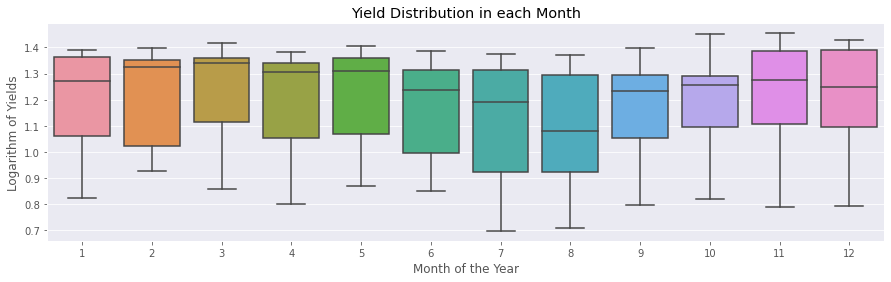

In [72]:
# add column with month indicator
df_aaa['month'] = df_aaa['date'].dt.month

# plot distribution for ln(yields) by month
ax = sns.boxplot(x="month", y="value", data=df_aaa)
ax.set_ylabel("Logarithm of Yields")
ax.set_xlabel("Month of the Year")
ax.set_title("Yield Distribution in each Month")
plt.show()

It is clear with this plot that there's monthly seasonality in the data, since the distribution of the series varies with the month of year. We can see that these variations go away once we apply the first difference to the series.

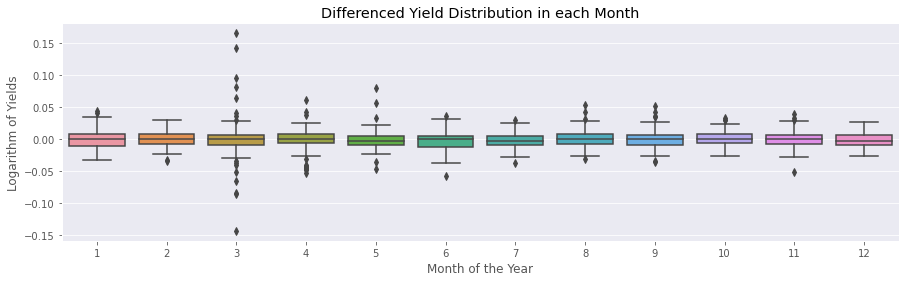

In [74]:
# plot distribution for ln(yields) by month
ax = sns.boxplot(x="month", y="diff", data=df_aaa)
ax.set_ylabel("Logarithm of Yields")
ax.set_xlabel("Month of the Year")
ax.set_title("Differenced Yield Distribution in each Month")
plt.show()

### Stationary ARMA Model

For the initial ARMA modeling, let's first estimate the parameters q and p through the autocorrelation and partial autocorrelation of the series.

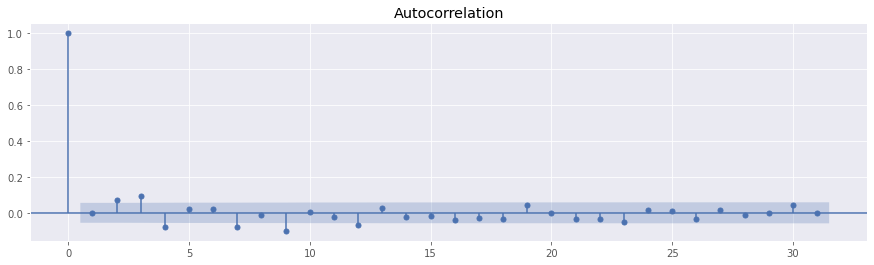

In [80]:
plot_acf(df_aaa['diff'].dropna())
plt.show()

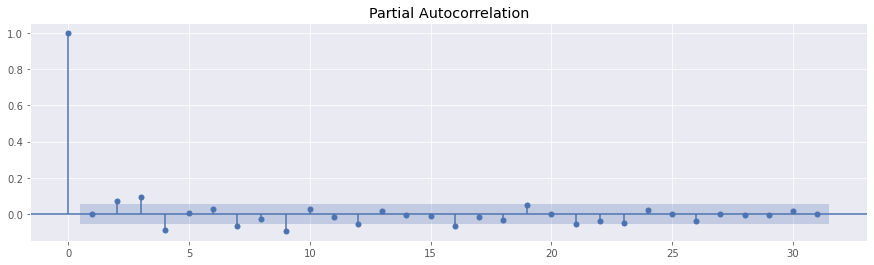

In [82]:
plot_pacf(df_aaa['diff'].dropna())
plt.show()

From the autocorrelation plot we can estimate $q=12$, and from the partial autocorrelation plot, we can estimate $p=9$. Now, we can fit the model and verify the results.

In [107]:
arma_model = arima(df_aaa['diff'].dropna(), order=(9,0,12))
res = arma_model.fit()
print(res.summary())

/home/josebarretto/anaconda3/envs/ftd/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/josebarretto/anaconda3/envs/ftd/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/josebarretto/anaconda3/envs/ftd/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/josebarretto/anaconda3/envs/ftd/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                   diff   No. Observations:                 1250
Model:                ARIMA(9, 0, 12)   Log Likelihood                3375.150
Date:                Sun, 12 Sep 2021   AIC                          -6704.301
Time:                        18:44:36   BIC                          -6586.290
Sample:                             0   HQIC                         -6659.937
                               - 1250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.000     -0.718      0.473      -0.001       0.000
ar.L1         -0.0520      2.073     -0.025      0.980      -4.115       4.011
ar.L2         -0.1794      1.055     -0.170      0.8

## NYSE Stock Yields

### Load the Data

In [ ]:
# Loads data and makes small modifications on the df
df_nyse = pd.read_csv("datasets/NYSE_stock_yields.csv", na_values='.')
df_nyse['DATE'] = pd.to_datetime(df_nyse['DATE'], format='%Y-%m-%d')
df_nyse.rename(columns={'DATE': 'date', 'M1346BUSM156NNBR': 'value'}, inplace=True)
df_nyse.dropna(inplace=True)

# Applies log-transform
df_nyse['value'] = np.log(df_nyse['value'])

# Plots the time series
plt.plot(df_nyse['date'], df_nyse['value'])
plt.title("NYSE Stock Yields")
plt.xlabel("Date")
plt.ylabel("Logarithm of Yields (%)")
plt.show()

### Augmented Dickey-Fuller Test

### Seasonality Analysis

### Stationary ARMA Model

## US Treasury Bond Yields

### Load the Data

In [ ]:
# Loads data and makes small modifications on the df
df_us = pd.read_csv("datasets/US_govbonds_yields.csv", na_values='.')
df_us['DATE'] = pd.to_datetime(df_us['DATE'], format='%Y-%m-%d')
df_us.rename(columns={'DATE': 'date', 'IRLTLT01USM156N': 'value'}, inplace=True)
df_us.dropna(inplace=True)

# Applies log-transform
df_us['value'] = np.log(df_us['value'])

# Plots the time series
plt.plot(df_us['date'], df_us['value'])
plt.title("US Governament Bond Yields")
plt.xlabel("Date")
plt.ylabel("Logarithm of Yields (%)")
plt.show()

### Augmented Dickey-Fuller Test

### Seasonality Analysis

### Stationary ARMA Model